In [65]:
import json
import ujson
import subprocess
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import copy
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.ticker import LogLocator, LogFormatter

import numpy as np

def scale_to_log(values, min_val=1, max_val=4000, base=10):
    """
    将数值列表缩放到对数尺度，并限制在[min_val, max_val]之间
    
    参数:
    - values: 数值列表或数组
    - min_val: 对数尺度下的最小值
    - max_val: 对数尺度下的最大值
    - base: 对数的底
    
    返回:
    - scaled_values: 缩放后的数值列表
    """
    # 确保所有值都是正值，避免对数中的负数和零
    positive_values = np.clip(values, a_min=min_val, a_max=max_val)
    
    # 计算对数值
    log_values = np.log(positive_values) / np.log(base)

    # 计算对数尺度上的最小值和最大值
    log_min = np.log(min_val) / np.log(base)
    log_max = np.log(max_val) / np.log(base)

    # 将对数值线性映射到[min_val, max_val]
    scaled_values = ((log_values - log_min) / (log_max - log_min)) * (max_val - min_val) + min_val
    
    return scaled_values


class CategoryStats:
    def __init__(self, file_path):
        self.input_file_path = file_path
        self.EBM_classification = { 
                    "cost": 0,
                    "diagnosis": 0,
                    "etiology": 0,
                    "prevention": 0,
                    "prognosis": 0,
                    "therapy": 0,
                    # "others": 0,
                    # "error": 0
                }
        self.question_nlp_classification = {
            "comparative": 0,
            "definitional": 0,
            "descriptive": 0,
            "directive": 0,
            "evaluative": 0,
            "explanatory": 0,
            "factual": 0,
            "hypothetical": 0,
            "opinion": 0,
            "procedural": 0,
            "referential": 0,
            "verification": 0,
            # "others": 0,
            # "error": 0
        }
        
        self.combined_classification = {
                    "cost": 0,
                    "diagnosis": 0,
                    "etiology": 0,
                    "prevention": 0,
                    "prognosis": 0,
                    "therapy": 0,
                    # "others": 0,
                    # "error": 0
                }
        for key in self.EBM_classification.keys():
            self.combined_classification[key] = copy.deepcopy(self.question_nlp_classification)

    def compute_stats(self):
        outer_keys = list(self.EBM_classification.keys())
        inner_keys = list(self.question_nlp_classification.keys())
        
        # get line number
        line_num = subprocess.run(['wc', '-l', self.input_file_path], stdout=subprocess.PIPE)  
        line_count = int(line_num.stdout.split()[0])
        
        with open(self.input_file_path, "r", encoding="utf-8", errors="ignore") as fin:
            for idx, line in enumerate(tqdm(fin, total=line_count)):
                try:
                    content = ujson.loads(line.replace("\n", "").replace("\\/", "/"))
                    
                    # EBM Category
                    if content["EBM_category"] in self.EBM_classification:
                        self.EBM_classification[content["EBM_category"]] += 1

                    # NLP Category
                    if content["nlp_category"] in self.question_nlp_classification:
                        self.question_nlp_classification[content["nlp_category"]] += 1
                   
                    # Combined Category
                    if content["EBM_category"] in self.combined_classification and content["nlp_category"] in self.combined_classification[content["EBM_category"]]:
                        self.combined_classification[content["EBM_category"]][content["nlp_category"]] += 1
                    else:
                        pass
                    
                except Exception as e:
                    print(f"Error in line {idx}: {e}")
                    print(line)
        
        print("EBM_category", self.EBM_classification)
        print("nlp_category", self.question_nlp_classification)
            
        # with open(output_file_path, "w", encoding="utf-8") as fout:
        #     fout.write(json.dumps({"line_count": line_count}, indent=4))
    
    # 用于转换为在 echarts 中绘图的数据
    def combined_stats_transform(self):
        combined_data = [] # 2-dimensional list
        outer_idx, inner_idx = 0, 0
        outer_keys = self.combined_classification.keys()
        for outer_key, inner_dict in self.combined_classification.items():
            inner_keys = inner_dict.keys()
            for inner_key, value in inner_dict.items():
                if outer_key not in ["others", "error"] and inner_key not in ["others", "error"]:
                    combined_data.append([outer_idx, inner_idx, value])
                else:
                    print("Error: outer_key or inner_key is not in the list")
                inner_idx += 1
            outer_idx += 1
            inner_idx = 0
        print("transformed_list", combined_data)
        return combined_data
    
    def adjust_combined_data(self):
        outer_keys = list(self.combined_classification.keys())
        print(outer_keys)
        for outer_key, inner_dict in self.combined_classification.items():
            inner_keys = list(inner_dict.keys())
    
    def barchart_visualization(self):
        EBM_categories = self.EBM_classification.keys() 
        plt.figure(figsize=(8, 6))
        plt.bar(EBM_categories, self.EBM_classification.values(), color='skyblue')
        plt.title('EBM_categories')
        plt.xlabel('Category')
        plt.ylabel('Number')
        plt.show()
        
        nlp_categories = self.question_nlp_classification.keys()
        plt.figure(figsize=(8, 6))
        plt.bar(nlp_categories, self.question_nlp_classification.values(), color='skyblue')
        plt.title('NLP')
        plt.xlabel('Category')
        plt.ylabel('Number')
        plt.xticks(rotation=-90)
        plt.show()
    
    def barchart_3d_visualization(self):
        EBM_categories = self.EBM_classification.keys()
        nlp_categories = self.question_nlp_classification.keys()
        
        # 创建网格
        x_pos, y_pos = np.meshgrid(np.arange(len(EBM_categories)), np.arange(len(nlp_categories)))
        x_pos = x_pos.flatten()
        y_pos = y_pos.flatten()
        
        EBM_values = self.EBM_classification.values()
        nlp_values = self.question_nlp_classification.values()
        
        combined_values = []
        for outer_key, inner_dict in self.combined_classification.items():
            for inner_key, value in inner_dict.items():
                value = self.combined_classification.get(outer_key, {}).get(inner_key, 1)  # 避免dz中出现0
                combined_values.append(value)
        # combined_values = self.combined_classification
        # combined_values = [list(x) for x in combined_values]
        print(combined_values)
        combined_values = scale_to_log(combined_values)
        
        # params
        z_pos = np.zeros_like(x_pos)
        dx = dy = 0.8  # 柱子的宽度
        dz = np.array(combined_values)
        
        print(x_pos.shape, y_pos.shape, dz.shape)
        assert x_pos.shape == y_pos.shape == dz.shape
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        # 绘制柱状图
        # colors = ['#E59191','#FAC5BD', '#F4DFDA', '#CCE4F0', '#AECFD4','#5A9CB4'] # plt.cm.viridis(dz / max(dz))  # 根据高度生成颜色
        colors = ['#F9FDCD', '#D5EEB3', '#8FD3BA', '#48B5C2', '#217EB6', '#234C9F']
        # 创建一个线性分段颜色映射
        cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

        # 根据z值归一化到[0, 1]区间
        # norm = plt.Normalize(min(dz), max(dz))
        norm = Normalize(vmin=max(min(dz), 1), vmax=4000)
        # ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, color='skyblue')
        
        # 设置z轴为log scale
        ax.set_zscale('log')
        ax.set_zlim(1, 4000)  # 设置z轴的最大值为4000，最小值为1（避免0）
        ax.zaxis.set_major_locator(LogLocator(base=10.0))
        ax.zaxis.set_major_formatter(LogFormatter())
        ax.computed_zorder = False
        
        for i in range(len(x_pos)):
            print("x_pos, y_pos", x_pos[i], y_pos[i])
            color = cmap(norm(dz[i]))
            ax.bar3d(x_pos[i], y_pos[11 - i], z_pos[i], dx, dy, dz[i], color=color, shade=True)
        # ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, color=norm)
        # 将数据按照 x_pos 升序、y_pos 降序排序

        # 设置x轴标签
        ax.set_xticks(np.arange(len(EBM_categories)) + 0.4)
        ax.set_xticklabels(EBM_categories, rotation=45)
        # 设置y轴标签
        ax.set_yticks(np.arange(len(nlp_categories)) + 0.4)
        ax.set_yticklabels(nlp_categories, rotation=-45)

        # 设置z轴标签
        ax.set_zlabel('Values')
        
        # 设置标题
        ax.set_title('3D Bar Chart with Two Orthogonal Categories')
        # 显示颜色条
        mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        mappable.set_array([])
        fig.colorbar(mappable, ax=ax, orientation='vertical')
        # 显示图表
        plt.tight_layout()
        plt.savefig('3d_barchart.svg', format='svg', bbox_inches='tight')  # Save as SVG file
        plt.show()

  9%|▊         | 15913/182822 [00:00<00:01, 159119.91it/s]

100%|██████████| 182822/182822 [00:01<00:00, 155927.12it/s]


EBM_category {'cost': 7494, 'diagnosis': 92139, 'etiology': 34121, 'prevention': 11817, 'prognosis': 9889, 'therapy': 27362}
nlp_category {'comparative': 4903, 'definitional': 12955, 'descriptive': 2053, 'directive': 5099, 'evaluative': 265, 'explanatory': 13535, 'factual': 115395, 'hypothetical': 526, 'opinion': 99, 'procedural': 3452, 'referential': 686, 'verification': 23854}


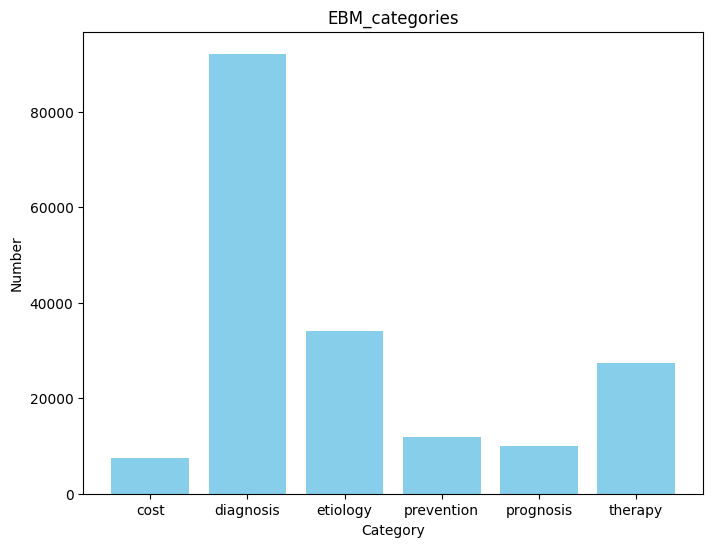

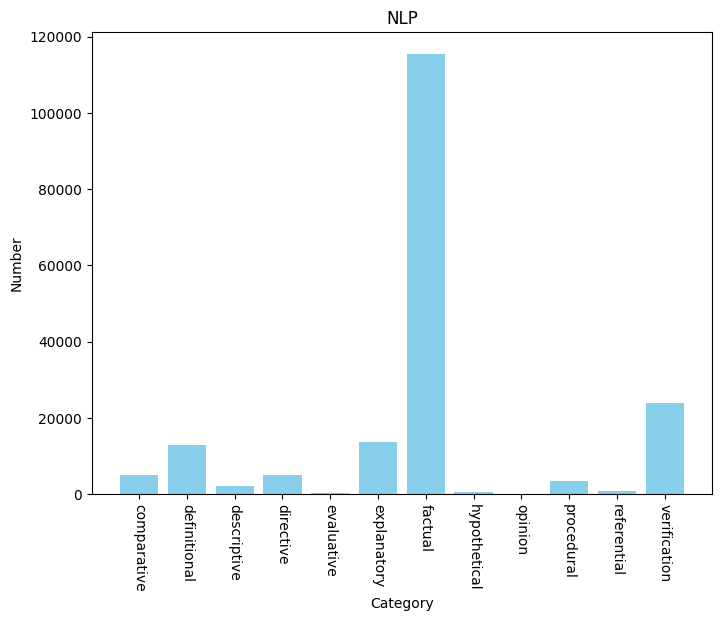

/tmp/ipykernel_245635/4059226006.py:218: UserWarning: Attempt to set non-positive zlim on a log-scaled axis will be ignored.
  ax.set_zscale('log')


[17, 26, 1, 2, 3, 11, 196, 0, 0, 7, 0, 22, 1679, 5377, 1161, 1419, 50, 3188, 57231, 118, 8, 614, 360, 13504, 567, 683, 22, 25, 7, 6083, 17396, 63, 1, 32, 44, 2015, 111, 242, 41, 413, 16, 269, 2915, 37, 2, 304, 7, 495, 187, 60, 9, 18, 18, 351, 1750, 81, 0, 39, 4, 153, 872, 398, 40, 2708, 97, 1013, 11783, 59, 10, 1623, 17, 1587]
(72,) (72,) (72,)
x_pos, y_pos 0 0
x_pos, y_pos 1 0
x_pos, y_pos 2 0
x_pos, y_pos 3 0
x_pos, y_pos 4 0
x_pos, y_pos 5 0
x_pos, y_pos 0 1
x_pos, y_pos 1 1
x_pos, y_pos 2 1
x_pos, y_pos 3 1
x_pos, y_pos 4 1
x_pos, y_pos 5 1
x_pos, y_pos 0 2
x_pos, y_pos 1 2
x_pos, y_pos 2 2
x_pos, y_pos 3 2
x_pos, y_pos 4 2
x_pos, y_pos 5 2
x_pos, y_pos 0 3
x_pos, y_pos 1 3
x_pos, y_pos 2 3
x_pos, y_pos 3 3
x_pos, y_pos 4 3
x_pos, y_pos 5 3
x_pos, y_pos 0 4
x_pos, y_pos 1 4
x_pos, y_pos 2 4
x_pos, y_pos 3 4
x_pos, y_pos 4 4
x_pos, y_pos 5 4
x_pos, y_pos 0 5
x_pos, y_pos 1 5
x_pos, y_pos 2 5
x_pos, y_pos 3 5
x_pos, y_pos 4 5
x_pos, y_pos 5 5
x_pos, y_pos 0 6
x_pos, y_pos 1 6
x_pos, 

/tmp/ipykernel_245635/4059226006.py:251: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


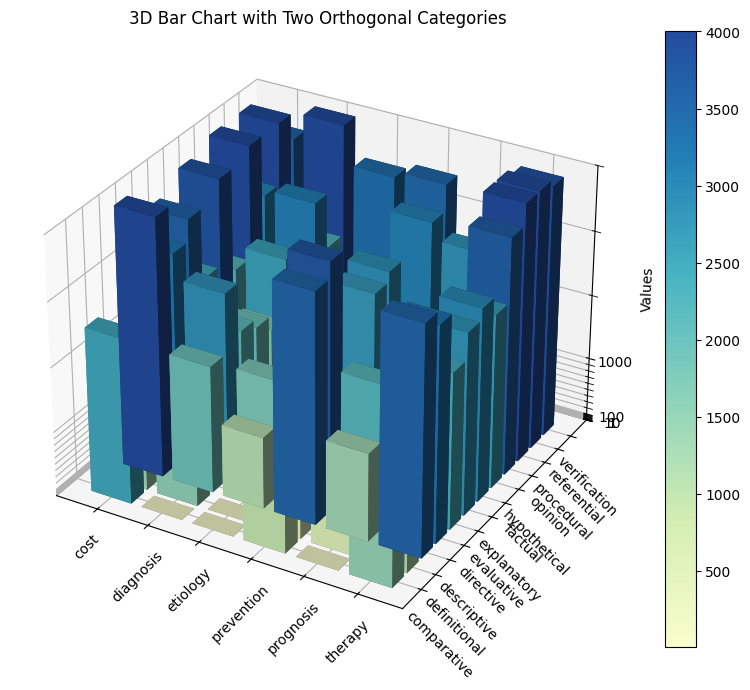

In [66]:
category_stats = CategoryStats("/cpfs/29f69eb5e2e60f26/code/sft_intern/keerlu/medical_RAG/RAG/classification/output/MedMCQA/train.json")
category_stats.compute_stats()
# category_stats.adjust_combined_data()
category_stats.barchart_visualization()
category_stats.barchart_3d_visualization()

100%|██████████| 34253/34253 [00:00<00:00, 196659.31it/s]


EBM_category {'cost': 1578, 'diagnosis': 15598, 'etiology': 5402, 'prevention': 2291, 'prognosis': 2093, 'therapy': 7291}
nlp_category {'comparative': 530, 'definitional': 3827, 'descriptive': 2181, 'directive': 6759, 'evaluative': 239, 'explanatory': 1706, 'factual': 10859, 'hypothetical': 288, 'opinion': 216, 'procedural': 4749, 'referential': 344, 'verification': 2555}


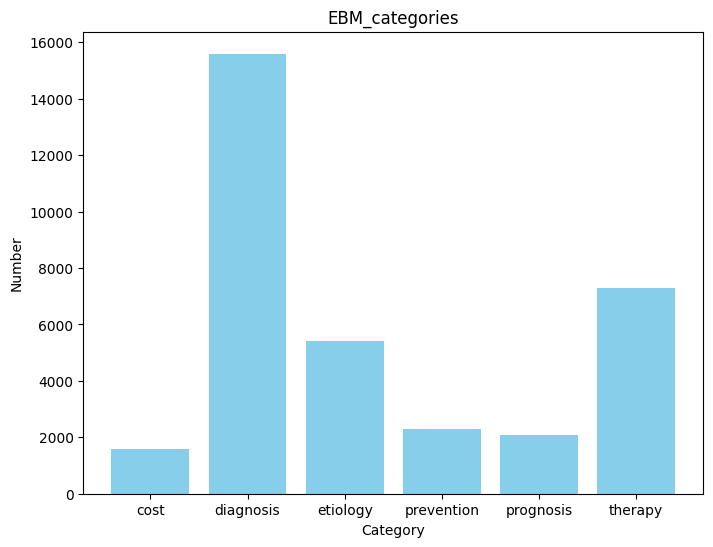

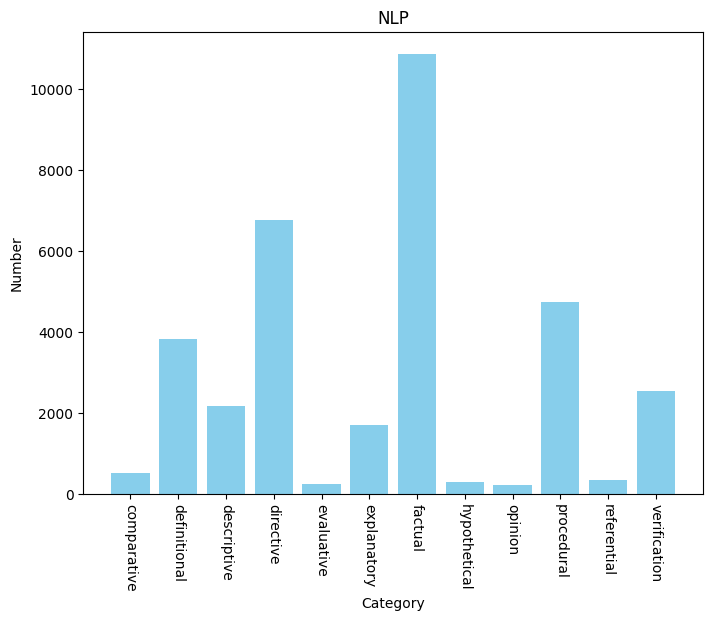

/tmp/ipykernel_245635/4059226006.py:218: UserWarning: Attempt to set non-positive zlim on a log-scaled axis will be ignored.
  ax.set_zscale('log')


[0, 10, 0, 8, 1, 1, 24, 0, 2, 6, 0, 3, 196, 1090, 1394, 3116, 8, 190, 5729, 62, 0, 375, 35, 754, 25, 442, 108, 296, 0, 890, 1854, 8, 1, 9, 12, 146, 1, 31, 13, 347, 2, 21, 130, 1, 1, 192, 11, 29, 15, 15, 62, 58, 8, 38, 253, 23, 7, 47, 3, 22, 35, 127, 42, 979, 6, 105, 472, 17, 5, 3634, 55, 229]
(72,) (72,) (72,)
x_pos, y_pos 0 0
x_pos, y_pos 1 0
x_pos, y_pos 2 0
x_pos, y_pos 3 0
x_pos, y_pos 4 0
x_pos, y_pos 5 0
x_pos, y_pos 0 1
x_pos, y_pos 1 1
x_pos, y_pos 2 1
x_pos, y_pos 3 1
x_pos, y_pos 4 1
x_pos, y_pos 5 1
x_pos, y_pos 0 2
x_pos, y_pos 1 2
x_pos, y_pos 2 2
x_pos, y_pos 3 2
x_pos, y_pos 4 2
x_pos, y_pos 5 2
x_pos, y_pos 0 3
x_pos, y_pos 1 3
x_pos, y_pos 2 3
x_pos, y_pos 3 3
x_pos, y_pos 4 3
x_pos, y_pos 5 3
x_pos, y_pos 0 4
x_pos, y_pos 1 4
x_pos, y_pos 2 4
x_pos, y_pos 3 4
x_pos, y_pos 4 4
x_pos, y_pos 5 4
x_pos, y_pos 0 5
x_pos, y_pos 1 5
x_pos, y_pos 2 5
x_pos, y_pos 3 5
x_pos, y_pos 4 5
x_pos, y_pos 5 5
x_pos, y_pos 0 6
x_pos, y_pos 1 6
x_pos, y_pos 2 6
x_pos, y_pos 3 6
x_pos, y

/tmp/ipykernel_245635/4059226006.py:251: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


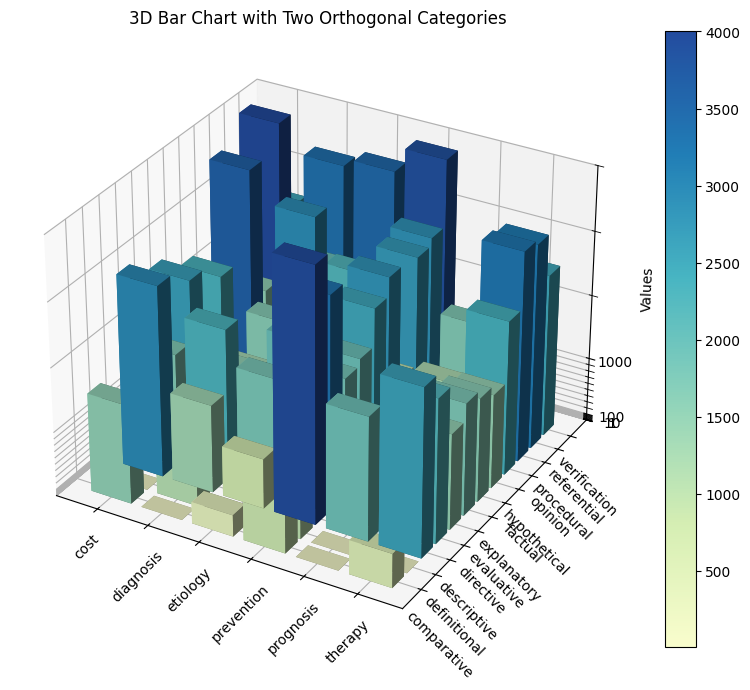

In [67]:
category_stats = CategoryStats("/cpfs/29f69eb5e2e60f26/code/sft_intern/keerlu/medical_RAG/RAG/classification/output/MedQA/Mainland/chinese_qbank.jsonl")
category_stats.compute_stats()
# category_stats.adjust_combined_data()
category_stats.barchart_visualization()
category_stats.barchart_3d_visualization()

100%|██████████| 14369/14369 [00:00<00:00, 123627.59it/s]


EBM_category {'cost': 78, 'diagnosis': 8125, 'etiology': 2038, 'prevention': 459, 'prognosis': 556, 'therapy': 3113}
nlp_category {'comparative': 263, 'definitional': 46, 'descriptive': 31, 'directive': 3350, 'evaluative': 85, 'explanatory': 4173, 'factual': 5712, 'hypothetical': 221, 'opinion': 7, 'procedural': 252, 'referential': 50, 'verification': 179}


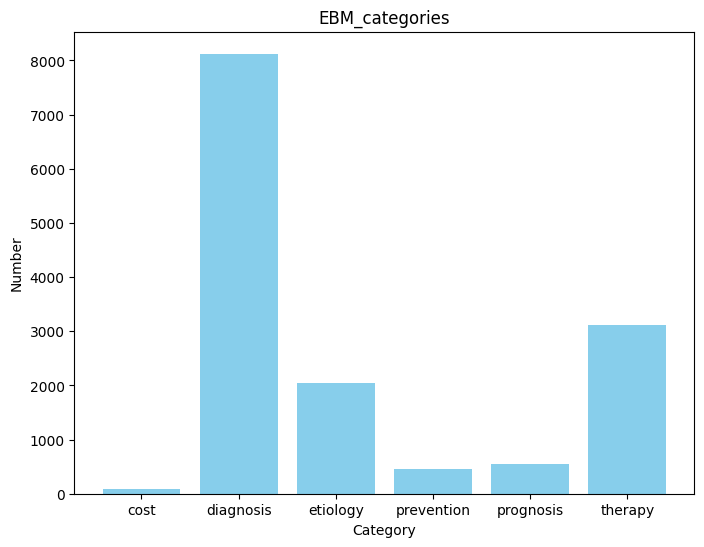

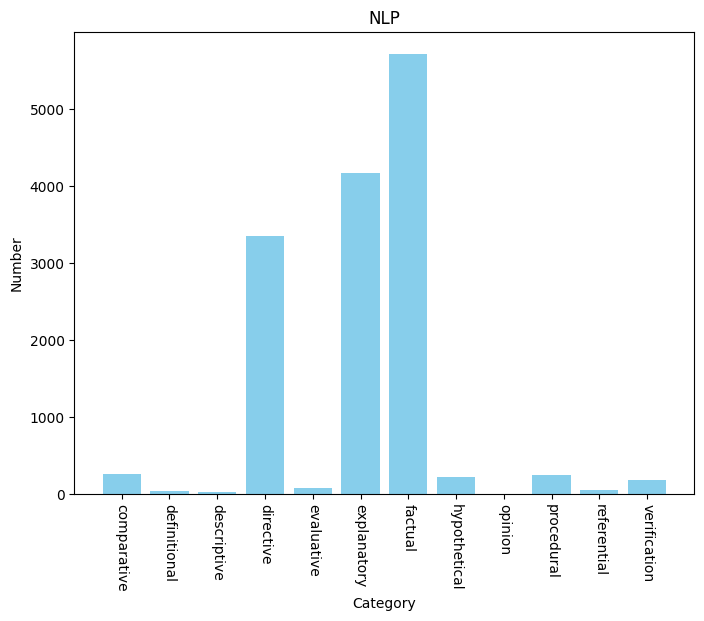

/tmp/ipykernel_245635/4059226006.py:218: UserWarning: Attempt to set non-positive zlim on a log-scaled axis will be ignored.
  ax.set_zscale('log')


[1, 0, 1, 3, 0, 0, 2, 1, 0, 0, 0, 2, 107, 21, 24, 1291, 11, 2316, 4002, 72, 0, 40, 33, 120, 53, 1, 2, 12, 1, 1133, 746, 15, 0, 6, 1, 10, 5, 1, 0, 142, 4, 71, 86, 25, 0, 39, 1, 6, 15, 1, 0, 18, 10, 171, 207, 51, 0, 7, 2, 6, 55, 5, 0, 1827, 32, 362, 557, 40, 0, 138, 4, 21]
(72,) (72,) (72,)
x_pos, y_pos 0 0
x_pos, y_pos 1 0
x_pos, y_pos 2 0
x_pos, y_pos 3 0
x_pos, y_pos 4 0
x_pos, y_pos 5 0
x_pos, y_pos 0 1
x_pos, y_pos 1 1
x_pos, y_pos 2 1
x_pos, y_pos 3 1
x_pos, y_pos 4 1
x_pos, y_pos 5 1
x_pos, y_pos 0 2
x_pos, y_pos 1 2
x_pos, y_pos 2 2
x_pos, y_pos 3 2
x_pos, y_pos 4 2
x_pos, y_pos 5 2
x_pos, y_pos 0 3
x_pos, y_pos 1 3
x_pos, y_pos 2 3
x_pos, y_pos 3 3
x_pos, y_pos 4 3
x_pos, y_pos 5 3
x_pos, y_pos 0 4
x_pos, y_pos 1 4
x_pos, y_pos 2 4
x_pos, y_pos 3 4
x_pos, y_pos 4 4
x_pos, y_pos 5 4
x_pos, y_pos 0 5
x_pos, y_pos 1 5
x_pos, y_pos 2 5
x_pos, y_pos 3 5
x_pos, y_pos 4 5
x_pos, y_pos 5 5
x_pos, y_pos 0 6
x_pos, y_pos 1 6
x_pos, y_pos 2 6
x_pos, y_pos 3 6
x_pos, y_pos 4 6
x_pos, y_pos 

/tmp/ipykernel_245635/4059226006.py:251: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


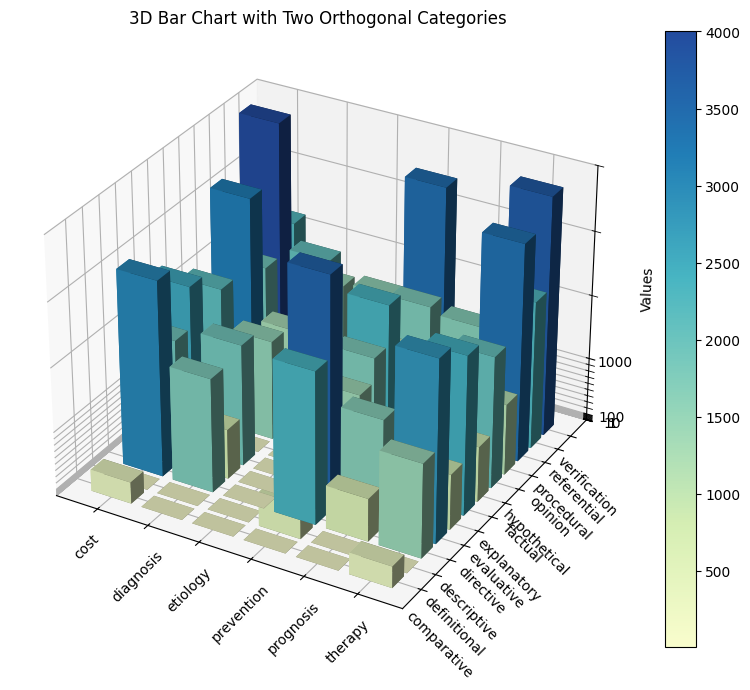

In [68]:
category_stats = CategoryStats("/cpfs/29f69eb5e2e60f26/code/sft_intern/keerlu/medical_RAG/RAG/classification/output/MedQA/US/US_qbank.jsonl")
category_stats.compute_stats()
# category_stats.adjust_combined_data()
category_stats.barchart_visualization()
category_stats.barchart_3d_visualization()